# CommonRoad Scenario Designer Tutorial
This tutorial shows how to use the map conversion APIs of the CommonRoad Scenario Designer.

## 1. Preparation
Before you proceed any further, make sure you have successfully installed the CommonRoad Scenario
Designer (cf. Readme or Docu).

## 2. OSM to CommonRoad

downloading map
writing custom bounds
reading File and creating graph
extract main layer
223 roads found
882 required nodes found
102 required nodes found
unknown id '145598916' for restriction element. skipping restriction
unknown id '95667930' for restriction element. skipping restriction
unknown id '4592554' for restriction element. skipping restriction
unknown id '124701357' for restriction element. skipping restriction
unknown id '149401684' for restriction element. skipping restriction
unknown id '292946855' for restriction element. skipping restriction
unknown id '124701356' for restriction element. skipping restriction
unknown id '149401687' for restriction element. skipping restriction
unknown id '849725319' for restriction element. skipping restriction
unknown id '144291470' for restriction element. skipping restriction
unknown id '144177635' for restriction element. skipping restriction
unknown id '28019891' for restriction element. skipping restriction
unknown id '292948255

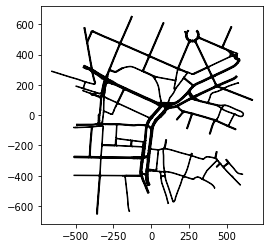

/media/sebastian/TUM/06_code/commonroad/cps/map-converter/commonroad-map-tool/crdesigner/conversion/osm2cr/converter_modules/intermediate_format.py:54: UserWarning: Lanelet 1990 invalid
  warnings.warn("Lanelet " + str(lanelet.lanelet_id) + " invalid")
/media/sebastian/TUM/06_code/commonroad/cps/map-converter/commonroad-map-tool/crdesigner/conversion/osm2cr/converter_modules/intermediate_format.py:54: UserWarning: Lanelet 2389 invalid
  warnings.warn("Lanelet " + str(lanelet.lanelet_id) + " invalid")


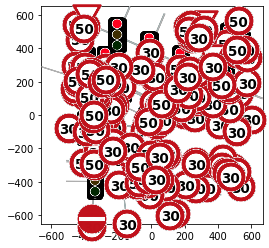

In [3]:
import crdesigner.conversion.osm2cr.converter_modules.converter as converter
import crdesigner.conversion.osm2cr.converter_modules.cr_operations.export as ex
from crdesigner.conversion.osm2cr import config
from crdesigner.conversion.osm2cr.converter_modules.osm_operations.downloader import download_around_map

# download a map
download_around_map(config.BENCHMARK_ID + '_downloaded.osm', 48.140289, 11.566272)

# open the map and convert it to a scenario
scenario = converter.GraphScenario(config.SAVE_PATH + config.BENCHMARK_ID + "_downloaded.osm")

# draw and show the scenario
scenario.plot()

# save the scenario as commonroad file
scenario.save_as_cr(config.SAVE_PATH + config.BENCHMARK_ID + ".xml")
# save the scenario as a binary
scenario.save_to_file(config.SAVE_PATH + config.BENCHMARK_ID + ".pickle")

# view the generated
ex.view_xml(config.SAVE_PATH + config.BENCHMARK_ID + ".xml")

## 3. OpenDRIVE to CommonRoad

## 3. Lanelet/Lanelet2 to CommonRoad and CommonRoad to Lanelet

## 3. CommonRoad to SUMO and Traffic Simulation Using SUMO

In [ ]:
import os
import matplotlib.pyplot as plt
import numpy as np

from commonroad.common.file_reader import CommonRoadFileReader
from commonroad.common.file_writer import CommonRoadFileWriter, OverwriteExistingFile
from commonroad.visualization.draw_dispatch_cr import draw_object

from crdesigner.conversion.sumo_map.config import SumoConfig
from crdesigner.conversion.sumo_map.cr2sumo import CR2SumoMapConverter

from sumocr.interface.sumo_simulation import SumoSimulation
from sumocr.visualization.video import create_video

# path config
output_folder = os.path.join(os.path.dirname(__file__), "../../crdesigner", "..", 'test',
                             "sumo_test_files")
scenario_name = "DEU_AAH-1_8007_T-1"
input_file = os.path.join(output_folder, scenario_name + '.xml')

scenario, planning_problem = CommonRoadFileReader(input_file).open()

# translate scenario to center
centroid = np.mean(np.concatenate(
    [l.center_vertices for l in scenario.lanelet_network.lanelets]),
    axis=0)
scenario.translate_rotate(-centroid, 0)
planning_problem.translate_rotate(-centroid, 0)

config = SumoConfig.from_scenario_name(scenario_name)

# # convert CR to sumo net
wrapper = CR2SumoMapConverter(scenario.lanelet_network, config)
wrapper.convert_to_net_file(output_folder)
tls_lanelet_id = 43513
traffic_light_system_generated = wrapper.auto_generate_traffic_light_system(tls_lanelet_id)

print(f"Generated Traffic Light System at {tls_lanelet_id}, {traffic_light_system_generated}")

# draw scenario after traffic light generation
plt.figure(figsize=(25, 25))
draw_object(wrapper.lanelet_network)
plt.axis('equal')
plt.autoscale()
plt.show()

# write generated traffic lights back to commonroad file
scenario.lanelet_network = wrapper.lanelet_network
# CommonRoadFileWriter(scenario,
#                      planning_problem,
#                      author=scenario.author,
#                      affiliation=scenario.affiliation,
#                      source=scenario.source,
#                      tags=scenario.tags,
#                      location=scenario.location).write_scenario_to_file(
#     os.path.join(output_folder,
#                  config.scenario_name + ".xml"),
#     overwrite_existing_file=True)

# run Simulation
simulation = SumoSimulation()
simulation.initialize(config, wrapper)

for t in range(config.simulation_steps):
    simulation.simulate_step()

simulation.stop()

# save resulting scenario
simulated_scenario = simulation.commonroad_scenarios_all_time_steps()
CommonRoadFileWriter(simulated_scenario,
                     planning_problem,
                     author=scenario.author,
                     affiliation=scenario.affiliation,
                     source=scenario.source,
                     tags=scenario.tags,
                     location=scenario.location).write_scenario_to_file(
    os.path.join(output_folder,
                 config.scenario_name + ".simulated.xml"),
    overwrite_existing_file=OverwriteExistingFile.ALWAYS)

print("creating video (this may take some time)")
create_video(simulation, 1, config.simulation_steps, output_folder)
